In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import motiflets.motiflets as mtfls
from tests.audio.lyrics import *
import motiflets_uni.motiflets as mtfls_uni
from motiflets_uni.plotting import Motiflets as Motiflets_uni
from sklearn.decomposition import PCA

/home/niyaz/Programme/miniconda3/envs/ubuntu-motiflets-mv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
k_max = 15
motif_length = 260
n_dims_rest = 3
n_dims_rest2 = 2

mpl.rcParams['figure.dpi'] = 300

path = "datasets/audio/"
ground_truth_path = "datasets/ground_truth/"


dataset = "The Rolling Stones - Paint It, Black"
ds_name = "The Rolling Stones - Paint It, Black"

audio_file_url = path + dataset + ".mp3"
audio_length_seconds, df, index_range = read_mp3(audio_file_url)
channels = ['MFCC 0', 'MFCC 1', 'MFCC 2', 'MFCC 3']
df = df.loc[channels]

new_len = int(df.shape[1] - ((df.shape[1]/audio_length_seconds) * 35))
audio_length_seconds_new = audio_length_seconds - 35

df = df.iloc[:,:new_len]
print((df.shape[1]/audio_length_seconds) * 4)


/home/niyaz/Programme/miniconda3/envs/ubuntu-motiflets-mv/lib/python3.8/site-packages/librosa/core/audio.py:171: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Length: 22050 in seconds 226.24364583333335 s
145.61292927655887


/home/niyaz/Bibliothek/GitHub/Bachlorarbeit/Code/motiflets-mv_tests/tests/audio/lyrics.py:14: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  audio_length_seconds = librosa.get_duration(filename=audio_file_url)


In [3]:
def norm_extent(df_full, dists, dims, elbows):
    dists_norm = []
    for elbow in range(len(dists)):
        if dims[elbow] is None:
            dists_norm.append(None)
            continue
        variance = 1
        for i, column in enumerate(df_full.T):
            if i in dims[elbow]:
                variance = variance + np.var(df_full.T[column].to_numpy())

        dists_norm.append(dists[elbow] / np.sqrt(variance / len(dims)))

    return dists_norm

In [4]:
ml_full = Motiflets(ds_name, df,
                dimension_labels=df.index,
                )

dists_full, motiflets_full, motiflets_dims_full, elbow_points_full = ml_full.fit_k_elbow(
                k_max,
                plot_elbows=False,
                plot_motifs_as_grid=False,
                motif_length=motif_length)

dists_full_norm = norm_extent(df, dists_full, motiflets_dims_full, elbow_points_full)

Data (4, 8236)


Chosen window-size: 260 in 2.6 s
Elbow Points [14]


In [5]:
ml_rest = Motiflets(ds_name, df,
                dimension_labels=df.index,
                n_dims=n_dims_rest
                )

dists_rest, motiflets_rest, motiflets_dims_rest, elbow_points_rest = ml_rest.fit_k_elbow(
                k_max,
                plot_elbows=False,
                plot_motifs_as_grid=False,
                motif_length=motif_length)

dists_rest_norm = norm_extent(df, dists_rest, motiflets_dims_rest, elbow_points_rest)

Data (4, 8236)


Chosen window-size: 260 in 2.2 s
Elbow Points [10]


In [6]:
ml_rest2 = Motiflets(ds_name, df,
                dimension_labels=df.index,
                n_dims=n_dims_rest2
                )

dists_rest2, motiflets_rest2, motiflets_dims_rest2, elbow_points_rest2 = ml_rest2.fit_k_elbow(
                k_max,
                plot_elbows=False,
                plot_motifs_as_grid=False,
                motif_length=motif_length)

dists_rest2_norm = norm_extent(df, dists_rest2, motiflets_dims_rest2, elbow_points_rest2)

Data (4, 8236)


Chosen window-size: 260 in 2.3 s
Elbow Points [10]


In [7]:
pca = PCA(n_components=1)
np_pca = pca.fit_transform(df.T)
series_pca = pd.Series(np_pca.flatten(), index=df.T.index, name='Rolling PCA')
series_pca.index.name = 'Seconds'

ml_uni = Motiflets_uni(ds_name, series_pca)

dists_uni, motiflets_uni, elbow_points_uni =  ml_uni.fit_k_elbow(
                k_max,
                plot_elbows=False,
                plot_motifs_as_grid=False,
                motif_length=motif_length)


Data 8236


Chosen window-size: 260 in 0.7 s
Elbow Points [2]


In [8]:
np_data = df.T.to_numpy()
mean_centered_data = np_data - np.mean(np_data, axis=0)

cov_matrix = np.cov(mean_centered_data, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

first_eigenvalue = eigenvalues[0]

dists_uni_norm = []
for u_dist in dists_uni:
     dists_uni_norm.append(u_dist / np.sqrt(first_eigenvalue))

print(dists_uni_norm)

[0.7599253181477015, 0.7599253181477015, 0.7599253181477015, 1.2167397494830583, 1.5506694960677672, 1.738219777760161, 2.040210788886292, 2.3640022084614256, 2.6152536087741214, 2.7751324614931643, 3.06332520128758, 3.259487188042673, 3.358174109824795, 3.4355516303033764, 3.470610555149258]


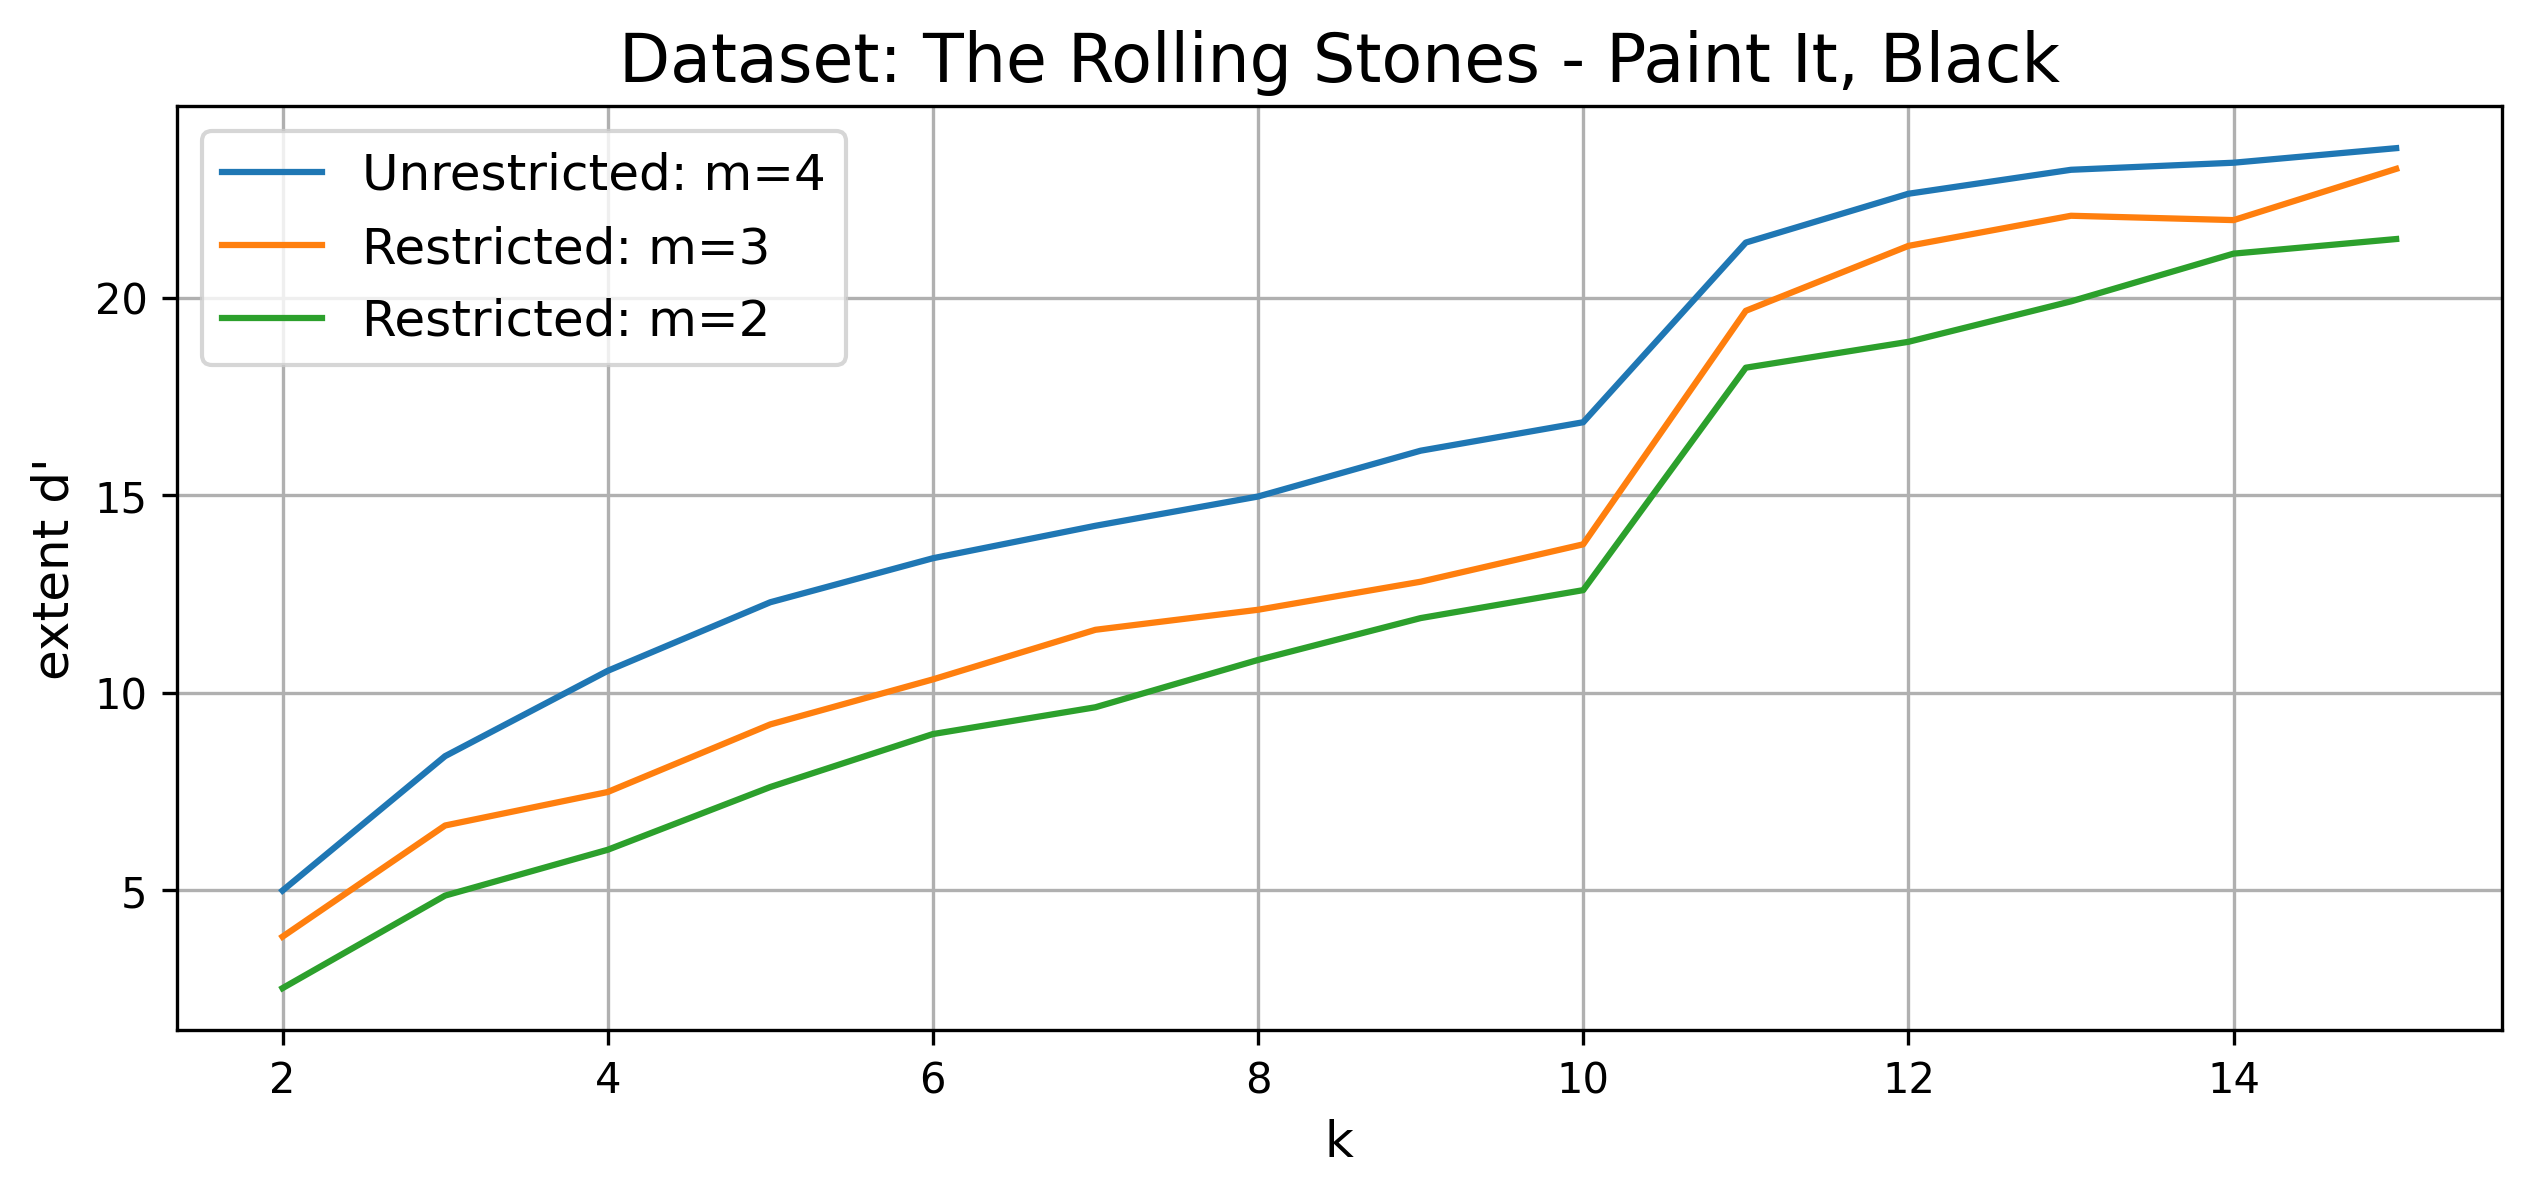

In [10]:
x_values = [x+2 for x in range(len(dists_full_norm[2:]))]

plt.figure(figsize=(10,4))

plt.plot(x_values, dists_full_norm[2:], label=f'Unrestricted: m={df.shape[0]}')
plt.plot(x_values, dists_rest_norm[2:], label=f'Restricted: m={n_dims_rest}')
plt.plot(x_values, dists_rest2_norm[2:], label=f'Restricted: m={n_dims_rest2}')
#plt.plot(dists_uni_norm[2:], label='PCA')

plt.title("Dataset: The Rolling Stones - Paint It, Black", fontsize=16)
plt.xlabel('k', fontsize=12)
plt.ylabel('extent d\'', fontsize=12)

plt.legend(fontsize=12)
plt.grid()
plt.savefig("../../Latex/BachelorarbeitFinal/Images/quant/rolling.pdf", bbox_inches='tight', dpi=600)
plt.show()